## 1. Requirements

In [1]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Set Args

In [3]:
eps = 0.007
use_cuda = True

## 3. Prepare Data

In [4]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [5]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]    mean that  the input image is scaled to [0.0, 1.0]
])

In [6]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes
    
    label2idx = {}
    print()
    for i, item in enumerate(idx2label) : # idx2label
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [16]:
print(idx2label)

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

In [7]:
normal_data = image_folder_custom_label(root = './data/', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

In [8]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))  # (寬，高)放大
    plt.imshow(np.transpose(npimg,(1,2,0))) # oprnCV img = cv2.imread(path)加载具有 HWC 布局（高度、宽度、通道）的图像，Pytorch 需要 CHW 布局。 所以我们必须做 np.transpose(image,(2,0,1))用于 HWC->CHW 转换。 
    plt.title(title)
    plt.show()

True Image & True Label


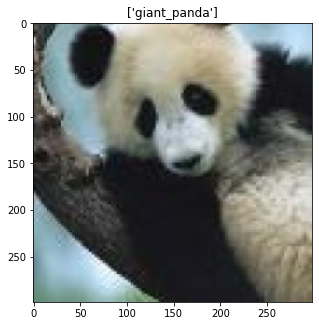

In [18]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()
print("True Image & True Label")
# normalize (bool, optional) – If True, shift the image to the range (0, 1), by the min and max values specified by value_range. 
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels]) 


## 4. Download the Inception v3

In [10]:
device = torch.device("cuda" if use_cuda else "cpu")

In [11]:
model = models.inception_v3(pretrained=True).to(device)

True Image & Predicted Label


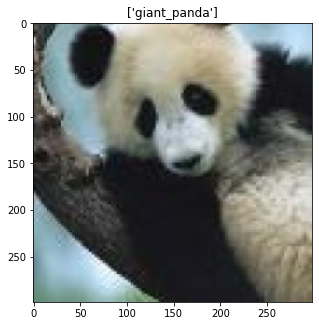

Accuracy of test text: 100.000000 %


In [12]:
print("True Image & Predicted Label")

#model.eval()的作用是不启用 Batch Normalization 和 Dropout。
# 轉換模型為 評估模式

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # tensor中所有元素的最大值
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    # ppyplt不支援gpu服務 image.cpu.data
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

## 5. Adversarial Attack

In [13]:
def fgsm_attack(model, loss, images, labels, eps) :
    
    # 數據和標籤發送到設備
    images = images.to(device)
    labels = labels.to(device)
    # 設置張亮的 requires_grad
    images.requires_grad = True
    # 透過模型 向前 傳遞張量        
    outputs = model(images)
    
    # 清空前次grad
    model.zero_grad()
    
    cost = loss(outputs, labels).to(device)
    # 根據loss進行backward計算gradient
    cost.backward()
    # 通過調整輸入圖像 的每個像素來創建擾動圖像 / sign 收集數據梯度元素符號 / eps 前面定義0.007
    attack_images = images + eps*images.grad.sign()
    # 剪切 維持[0,1]之間
    attack_images = torch.clamp(attack_images, 0, 1)
    
    return attack_images

In [14]:
loss = nn.CrossEntropyLoss()

Attack Image & Predicted Label


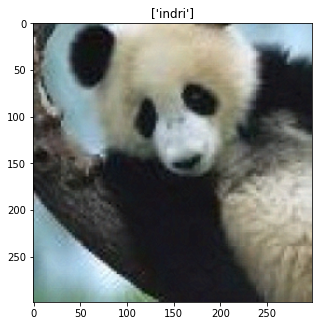

Accuracy of test text: 0.000000 %


In [15]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = fgsm_attack(model, loss, images, labels, eps).to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    #tensor中所有元素的最大值：
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))